In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import LeaveOneOut, GridSearchCV, cross_val_predict
from sklearn.model_selection import train_test_split

In [12]:
df = pd.read_excel("pm10s_classes500m.xlsx")
df["urban_pm10w"] = df["Urbanizado"] * df["pm10_weighted"]
df["transp_pm10w"] = df["Transporte"] * df["pm10_weighted"]
X = df[[
    "pm10_weighted",
    "Urbanizado",
    "Transporte",
    "urban_pm10w",
    "transp_pm10w"
]]
y = df['pm10']

param_grid = {
    'svr__kernel': ['linear', 'poly', 'rbf'],
    'svr__degree': [3],  # only used for 'poly'
    'svr__C': [0.1, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 5, 6, 7, 10, 15, 20, 25, 100],
    'svr__epsilon': [0.05, 0.10, 0.15, 0.2, 0.3, 0.4, 0.5]
}


In [13]:

def full_svr_diagnostics(X, y, param_grid, cv_strategy, label="model", feature_names=None, plot=True):
    results = []
    y = np.asarray(y)
    X = np.asarray(X)

    for kernel in param_grid["svr__kernel"]:
        for C in param_grid["svr__C"]:
            for epsilon in param_grid["svr__epsilon"]:
                if kernel == "poly":
                    degree = param_grid["svr__degree"][0]
                else:
                    degree = 3  # default

                model = Pipeline([
                    ('preprocessor', ColumnTransformer([
                        ('scale', StandardScaler(), [0, -2, -1]),
                        ('passthrough', 'passthrough', [i for i in range(1, X.shape[1] - 2)])
                    ], remainder='drop')),
                    ('svr', SVR(kernel=kernel, C=C, epsilon=epsilon, degree=degree))
                ])

                y_true_all, y_pred_all = [], []

                for train_idx, test_idx in cv_strategy.split(X):
                    model.fit(X[train_idx], y[train_idx])
                    y_pred = model.predict(X[test_idx])
                    y_true_all.extend(y[test_idx])
                    y_pred_all.extend(y_pred)

                r2 = r2_score(y_true_all, y_pred_all)
                rmse = np.sqrt(mean_squared_error(y_true_all, y_pred_all))
                mae = mean_absolute_error(y_true_all, y_pred_all)

                results.append({
                    label: f"{kernel}",
                    "kernel": kernel,
                    "C": C,
                    "epsilon": epsilon,
                    "r2": r2,
                    "rmse": rmse,
                    "mae": mae
                })

    results_df = pd.DataFrame(results)
    best_row = results_df.sort_values("r2", ascending=False).iloc[0]

    best_kernel = best_row["kernel"]
    best_C = best_row["C"]
    best_epsilon = best_row["epsilon"]
    best_degree = param_grid["svr__degree"][0] if best_kernel == "poly" else 3

    final_model = Pipeline([
        ('preprocessor', ColumnTransformer([
            ('scale', StandardScaler(), [0, -2, -1]),
            ('passthrough', 'passthrough', [i for i in range(1, X.shape[1] - 2)])
        ], remainder='drop')),
        ('svr', SVR(kernel=best_kernel, C=best_C, epsilon=best_epsilon, degree=best_degree))
    ])
    final_model.fit(X, y)
    y_pred_full = final_model.predict(X)
    residuals = y - y_pred_full

    print("SVR regression (APPLIED TO FULL DATA):")
    print(f"Best kernel: {best_kernel}, C: {best_C}, epsilon: {best_epsilon}")
    print(f"Refit R²:   {r2_score(y, y_pred_full):.3f}")
    print(f"Refit RMSE: {np.sqrt(mean_squared_error(y, y_pred_full)):.3f}")
    print(f"Refit MAE:  {mean_absolute_error(y, y_pred_full):.3f}")

    print("\nCross-validated (TEST-ONLY) metrics for best combination:")
    print(f"Kernel: {best_kernel}, C: {best_C}, Epsilon: {best_epsilon}")
    print(f"CV R²:    {best_row['r2']:.3f}")
    print(f"CV RMSE:  {best_row['rmse']:.3f}")
    print(f"CV MAE:   {best_row['mae']:.3f}")

    return {
        "best_model": final_model,
        "cv_results_df": results_df,
        "residuals": residuals
    }

In [7]:
result = full_svr_diagnostics(X, y, param_grid, LeaveOneOut())
results_df = result["cv_results_df"]

SVR regression (APPLIED TO FULL DATA):
Best kernel: linear, C: 1.5, epsilon: 0.05
Refit R²:   0.683
Refit RMSE: 5.520
Refit MAE:  4.115

Cross-validated (TEST-ONLY) metrics for best combination:
Kernel: linear, C: 1.5, Epsilon: 0.05
CV R²:    0.653
CV RMSE:  5.774
CV MAE:   4.377


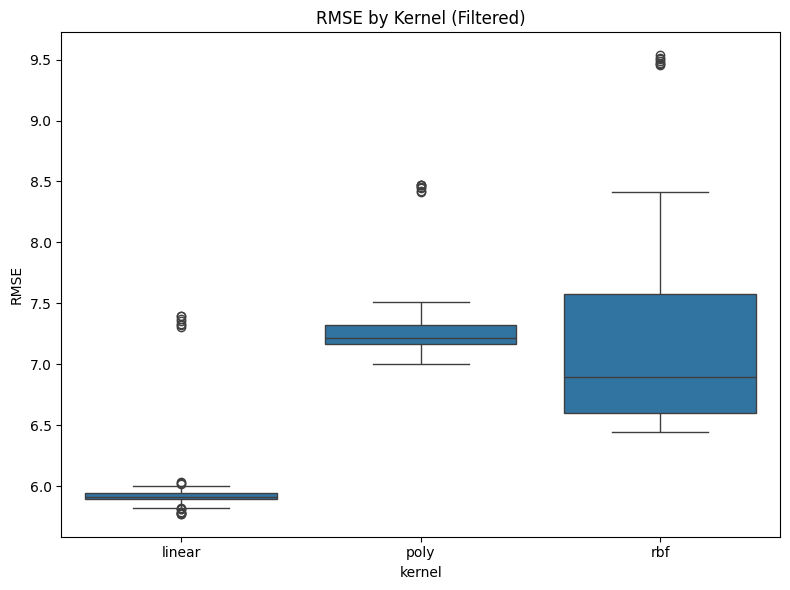

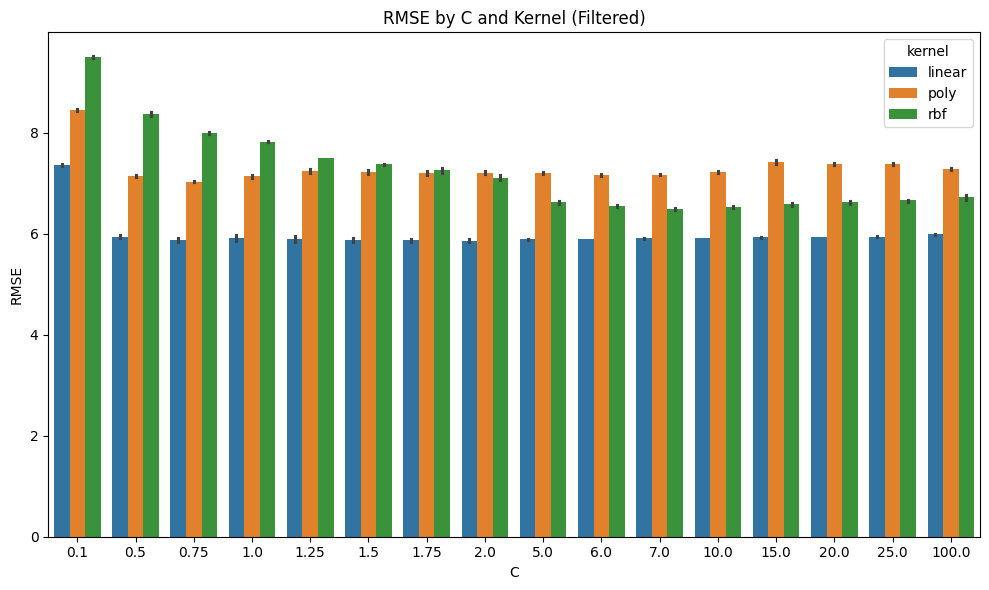

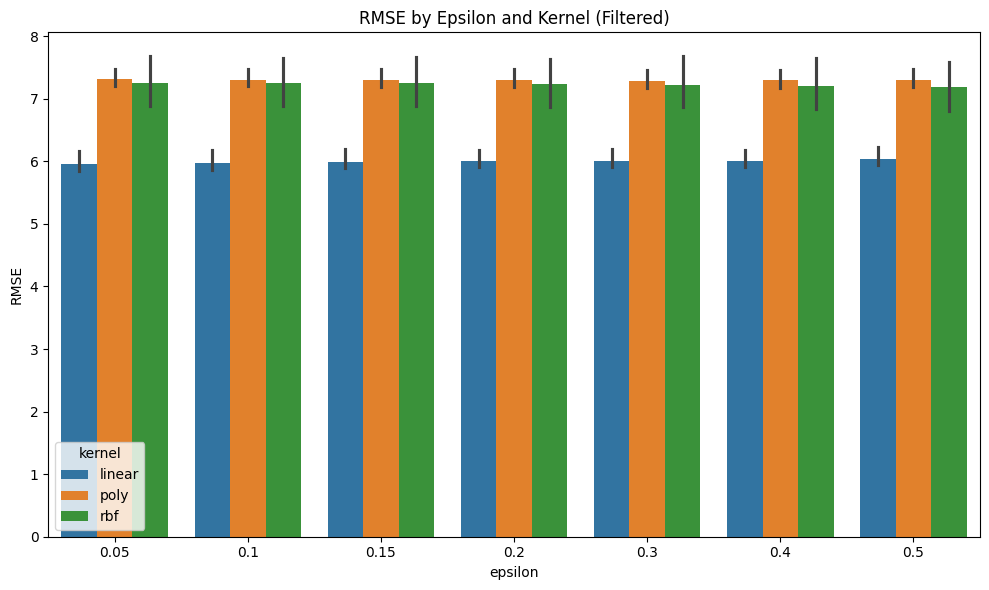

In [8]:


# Filter and plot
results_df["RMSE"] = results_df["rmse"]  # Already positive
filtered_df = results_df[results_df["RMSE"] < 30]

# Plot 1: RMSE by Kernel
plt.figure(figsize=(8, 6))
sns.boxplot(data=filtered_df, x='kernel', y='RMSE')
plt.title('RMSE by Kernel (Filtered)')
plt.tight_layout()
plt.show()

# Plot 2: RMSE by C and Kernel
plt.figure(figsize=(10, 6))
sns.barplot(data=filtered_df, x='C', y='RMSE', hue='kernel')
plt.title('RMSE by C and Kernel (Filtered)')
plt.tight_layout()
plt.show()

# Plot 3: RMSE by Epsilon and Kernel
plt.figure(figsize=(10, 6))
sns.barplot(data=filtered_df, x='epsilon', y='RMSE', hue='kernel')
plt.title('RMSE by Epsilon and Kernel (Filtered)')
plt.tight_layout()
plt.show()


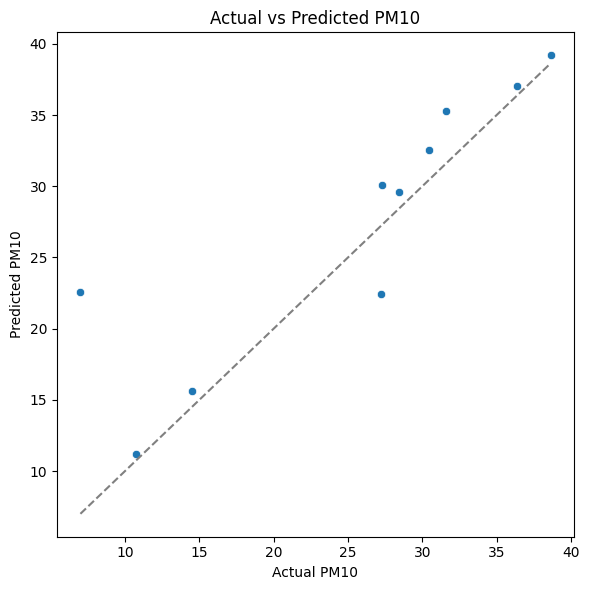

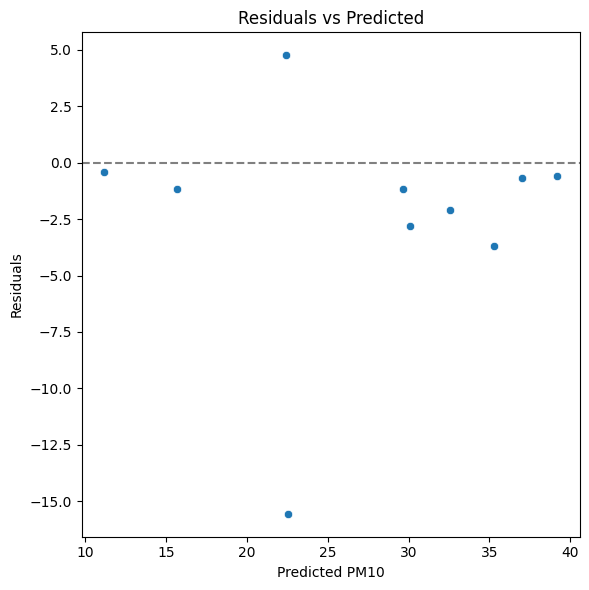

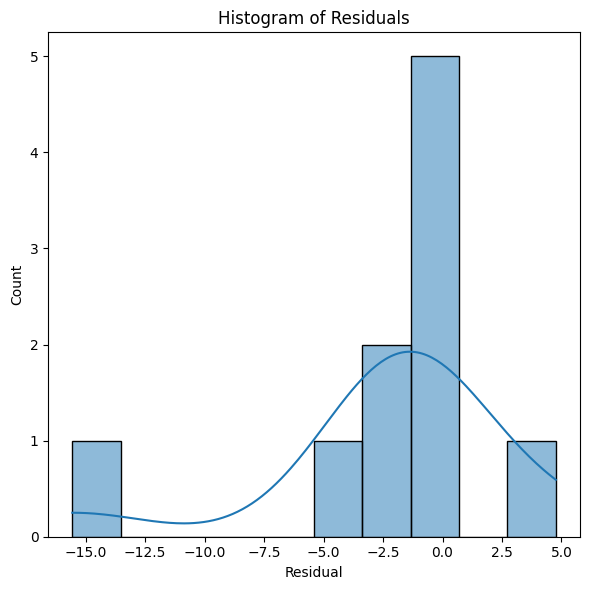

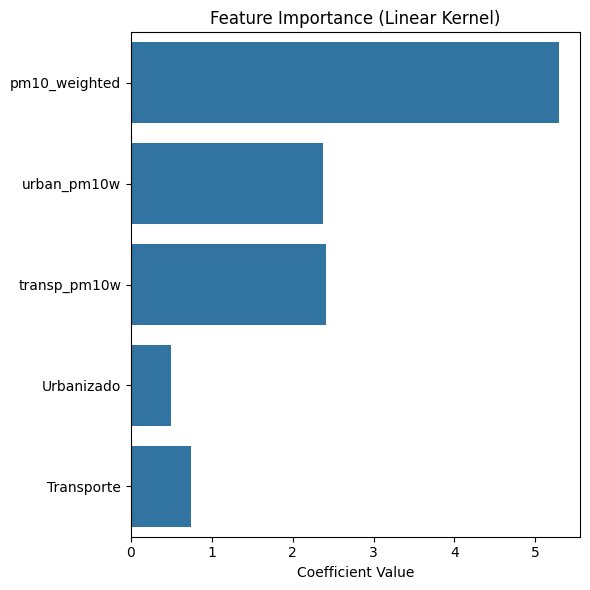

In [14]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10, random_state=42)

best_model = result["best_model"]
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

residuals = y_test - y_pred

# Plot 1: Actual vs Predicted
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='gray')
plt.xlabel("Actual PM10")
plt.ylabel("Predicted PM10")
plt.title("Actual vs Predicted PM10")
plt.tight_layout()
plt.show()

# Plot 2: Residuals vs Predicted
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel("Predicted PM10")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.tight_layout()
plt.show()

# Plot 3: Histogram of Residuals
plt.figure(figsize=(6, 6))
sns.histplot(residuals, kde=True, bins=10)
plt.xlabel("Residual")
plt.title("Histogram of Residuals")
plt.tight_layout()
plt.show()

# Plot 4: Feature Importance (only for linear kernel)
# Recover the fitted preprocessor and SVR
preprocessor_fitted = best_model.named_steps['preprocessor']
svr = best_model.named_steps['svr']

if svr.kernel == 'linear':
    # Manually define the column indices (you know the original order)
    original_columns = list(X.columns)
    scaled_idxs = [0, 3, 4]  # based on your scaling config
    passthrough_idxs = [i for i in range(len(original_columns)) if i not in scaled_idxs]

    # Construct the final order of features as seen by the model
    feature_names_in_model_order = (
        [original_columns[i] for i in scaled_idxs] + 
        [original_columns[i] for i in passthrough_idxs]
    )

    feature_importance = svr.coef_.flatten()

    # Safety check
    assert len(feature_importance) == len(feature_names_in_model_order), \
        "Mismatch in number of features and coefficients!"

    # Plot
    plt.figure(figsize=(6, 6))
    sns.barplot(x=feature_importance, y=feature_names_in_model_order)
    plt.title("Feature Importance (Linear Kernel)")
    plt.xlabel("Coefficient Value")
    plt.tight_layout()
    plt.show()
else:
    print("Feature importance is only available for linear kernel models.")


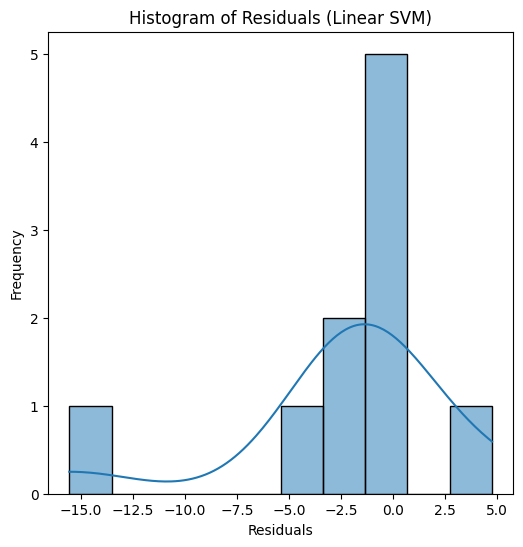

In [15]:
plt.figure(figsize=(6, 6))
sns.histplot(residuals, kde=True, bins=10)
plt.title("Histogram of Residuals (Linear SVM)")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()


In [16]:
svr = best_model.named_steps['svr']
w_scaled = svr.coef_.flatten()
b_scaled = svr.intercept_[0]


In [17]:
# Step 1: Extract the fitted scaler
scaler = best_model.named_steps['preprocessor'].transformers_[0][1]
scaled_idxs = best_model.named_steps['preprocessor'].transformers_[0][2]

# Step 2: SVR coefficients
svr = best_model.named_steps['svr']
w_scaled = svr.coef_.flatten()
b_scaled = svr.intercept_[0]

# Step 3: Reconstruct original feature order
original_columns = list(X.columns)
scaled_features = [original_columns[i] for i in scaled_idxs]
passthrough_features = [col for col in original_columns if col not in scaled_features]
final_feature_order = scaled_features + passthrough_features

# Step 4: Create full weight vector in correct order
mean = scaler.mean_
scale = scaler.scale_

# For scaled features: unscale
w_unscaled_scaled_part = w_scaled[:len(scaled_features)] / scale
b_unscaled = b_scaled - np.sum(w_scaled[:len(scaled_features)] * mean / scale)

# For binary passthrough features: unchanged
w_unscaled_passthrough = w_scaled[len(scaled_features):]  # already unscaled

# Combine
w_unscaled = np.concatenate([w_unscaled_scaled_part, w_unscaled_passthrough])

# Display as equation
eq_scaled = " + ".join([f"{coef:.4f}*{name}" for coef, name in zip(w_scaled, final_feature_order)])
eq_scaled = f"ŷ_scaled = {eq_scaled} + {b_scaled:.4f}"

eq_unscaled = " + ".join([f"{coef:.4f}*{name}" for coef, name in zip(w_unscaled, final_feature_order)])
eq_unscaled = f"ŷ_unscaled = {eq_unscaled} + {b_unscaled:.4f}"

print("SCALED SVR EQUATION:")
print(eq_scaled, "\n")

print("UNSCALED SVR EQUATION:")
print(eq_unscaled)


SCALED SVR EQUATION:
ŷ_scaled = 5.2874*pm10_weighted + 2.3802*urban_pm10w + 2.4097*transp_pm10w + 0.4990*Urbanizado + 0.7459*Transporte + 27.9557 

UNSCALED SVR EQUATION:
ŷ_unscaled = 0.9410*pm10_weighted + 0.1770*urban_pm10w + 0.2412*transp_pm10w + 0.4990*Urbanizado + 0.7459*Transporte + 1.8372
